<a href="https://colab.research.google.com/github/pds2021/a5-franzislytics/blob/assignment_5/Kopie_von_Schrauben__Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Practical Data Science 20/21*
# Programming Assignment 5 - Create your own App

In this programming assignment you'll build a model that serves as a foundation for your own app. To this end, you will create your own dataset, build a deep learning model on this data, and deploy it!

In [42]:
!pip install -Uqq fastai  # upgrade fastai on colab

In [43]:
from fastai.vision.all import *
from fastai.vision.widgets import *

__Google Drive integration__

If you want to store and access your downloaded data for this assignment you can use the following code:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir /content/drive/My\ Drive/pds_a5
%cd /content/drive/My\ Drive/pds_a5

## Develop an Application Idea

___Free your mind - this part is totally up to you.___

Think of an app that you'd like to build.
*   What useful app have you been missing?
*   Do you have any hobbies an app could be helpful for?
*   Is this a suitable classification or regression task? 
*   How could you get the data?


*Meine Idee ist eine Image Classification für Schrauben-Arten.
Dabei wird beispielsweise zwischen den Klassen Längsschlitz-, Kreuzschlitz- , Sechskant- und Torx-Schrauben unterschieden (der Einfachheit halber wird sich für dieses Modell auf diese 4 Klassen beschränkt, auch wenn es deutlich mehr Schraubenarten gibt).
Diese Classification könnte hilfreich sein, wenn Handwerker durch Roboter ersetzt werden oder allgemein für Maschinen in Produktionsunternehmen.
Zum Beispiel für die Erkennung der richtigen Schraube, deren Sortieren, oder auch für das Finden des passenden Schraubenschlüssels.
Natürlich ist die App auch hilfreich für Hobbyhandwerker oder Menschen, die zum ersten Mal Möbel zusammen bauen und sich nicht mit den Schraubenarten auskennen.*

You can get an inspiration from these Apps:

<table>
<tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/5.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/400">Guitar Classifier</a> by Christian Werner</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/6.png"><br><a href="https://forums.fast.ai/t/share-your-work-here/27676/340">Healthy or Not!</a> by Nikhil Utane </td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/7.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/333">Hummingbird Classifier</a> by Nissan Dookeran</td>
</tr><tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/8.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/409">Edible Mushroom?</a> by Ramon</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/9.png"><br> <a href="https://forums.fast.ai/t/share-your-work-here/27676/387">Cousin Recognizer</a> by Charlie Harrington</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/10.png"><br> <a href="https://forums.fast.ai/t/share-your-work-here/27676/386">Emotion Classifier</a> by Ethan Sutin and Team 26</td>
</tr><tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/11.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/350">American Sign Language</a> by Keyur Paralkar</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/12.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/355">Your City from Space</a> by Henri Palacci</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/13.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/367">Univariate TS as images using Gramian Angular Field</a> by Ignacio Oguiza</td>
</tr><tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/14.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/348">Face Expression Recognition</a> by Pierre Guillou</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/15.png"><br><a href="https://forums.fast.ai/t/share-your-work-here/27676/352">Tumor-normal sequencing</a> by Alena Harley</td><td>  </td>
</tr><table>

## Creating your own Dataset

Now you need to construct a dataset that allows you to train a model for your app. You learned about how to create a dataset in Lecture 7.

Here, you can follow the steps from the lecture or look into the following ressources:

*   A [tool](https://github.com/toffebjorkskog/ml-tools/blob/master/gi2ds.md) for excluding irrelevant images from Google Image Search results beforehand by @melonkernel
*   See this [post](https://www.christianwerner.net/tech/Build-your-image-dataset-faster/) about an alternative image downloader/cleaner by @cwerner
*   Of course, you can use your own data/images :) 

### 1. Dowload the data 
- You may use the helper functions from the lecture to get the image URLs
- Create a new folder at your defined `path`
- Use `download_image` to download the images into the corresponding (sub-)directories

In [73]:
import requests
import re
import json
from fastcore.foundation import L

def search_images_ddg(key,max_n=150):
    """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
    (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api and 
    https://github.com/fastai/fastbook/blob/master/utils.py)
    """
    url        = 'https://duckduckgo.com/'
    params     = {'q':key}
    res        = requests.post(url,data=params)
    searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
    if not searchObj: print('Token Parsing Failed !'); return
    requestUrl = url + 'i.js'
    headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0',
                 'referer': 'https://duckduckgo.com/'}
    params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
    urls       = []
    while True:
        try:
            res  = requests.get(requestUrl,headers=headers,params=params)
            data = json.loads(res.text)
            for obj in data['results']:
                urls.append(obj['image'])
                max_n = max_n - 1
                if max_n < 1: return L(set(urls))     # dedupe
            if 'next' not in data: return L(set(urls))
            requestUrl = url + data['next']
        except:
            pass

In [74]:
ims = search_images_ddg('Schraube')
len(ims)

136

In [75]:
pd.DataFrame({'urls':ims})

,urls
0,https://upload.wikimedia.org/wikipedia/commons/c/c8/Schraube.jpg
1,https://www.gratis-malvorlagen.de/wp-content/uploads/malvorlagen/Haushalt/Schraube-104x300.gif
2,http://www.toonpool.com/user/12400/files/lockere_schraube_1602105.jpg
3,https://storage.googleapis.com/3d_model_images/555/5550016/schraube-3d-model-vLrLqx9Zk_200.jpg
4,https://www.juraprofi.de/images/product_images/popup_images/jura-schraube-m4x14-64929-2.jpg
...,...
131,https://www.tuning-bikes.de/media/image/product/938/lg/titan-schraube-m5-x-12mm-innensechskant-konischer-kopf.jpg
132,https://www.bikehardest.net/shop/bilder/produkte/gross/Titan-Schraube-M4-x-25-Senkkopf-custom-torx-gold.jpg
133,http://1.bp.blogspot.com/_22MgU8S4z-k/S6p-4yeRlXI/AAAAAAAABGA/8rTWJO8XJRs/s1600/Schraube.JPG
134,http://shop.sommercable.com/out/pictures/master/product/1/a_3078_otsi1.jpg


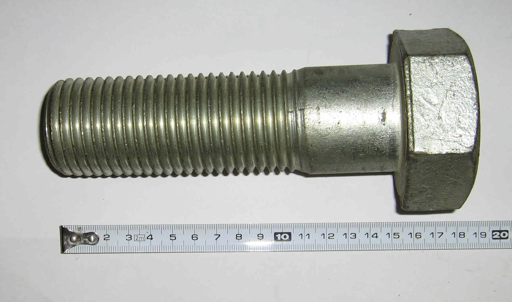

In [76]:
dest = 's1.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(512,512)

### 2. Verify Images
- First, create a list of all your images
- Use `verify_images` and `unlink` to remove broken images

In [77]:
#list
schrauben_types = 'Längsschlitz', 'Kreuzschlitz', 'Sechskant', 'Torx'
path = Path('Schrauben')

In [78]:
if not path.exists(): path.mkdir()
for o in schrauben_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} Schraube')
    download_images(dest, urls=results)

In [79]:
fns = get_image_files(path)
fns

(#688) [Path('Schrauben/Sechskant/00000033.png'),Path('Schrauben/Sechskant/00000126.jpg'),Path('Schrauben/Sechskant/00000071.jpg'),Path('Schrauben/Sechskant/00000046.jpg'),Path('Schrauben/Sechskant/00000003.jpg'),Path('Schrauben/Sechskant/00000026.jpg'),Path('Schrauben/Sechskant/00000136.JPG'),Path('Schrauben/Sechskant/00000018.jpg'),Path('Schrauben/Sechskant/00000094.jpg'),Path('Schrauben/Sechskant/00000053.jpg')...]

In [80]:
failed = verify_images(fns)
failed 

(#3) [Path('Schrauben/Sechskant/00000057.jpg'),Path('Schrauben/Sechskant/00000002.jpg'),Path('Schrauben/Kreuzschlitz/00000076.jpg')]

In [81]:
#unlink
failed.map(Path.unlink)

(#3) [None,None,None]

### 3. Create the DataBlock
For this, you need to think of:
- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

Use `RandomResizedCrop` for `item_tfms`with an image size of 224 px, and the appropriate `aug_transforms` as `batch_tfms`.

In [82]:
#datablock
schraub = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224),
    batch_tfms=aug_transforms())

### 4. Create the DataLoaders

In [83]:
dls = schraub.dataloaders(path)

### 5. Take a look at some of your pictures. 
Does everything look as expected?

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


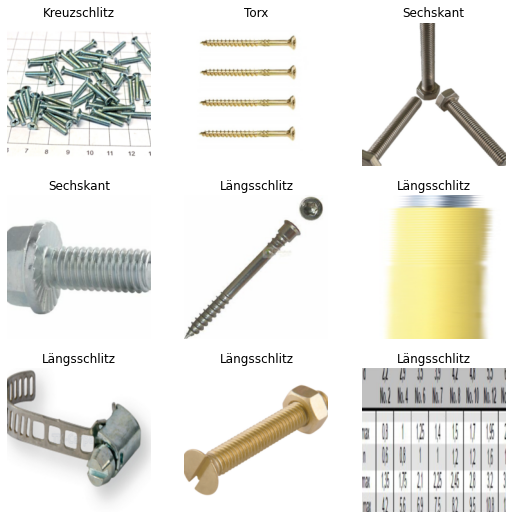

In [84]:
dls.valid.show_batch(max_n=9, nrows=3)

## Modeling

### 6. Create a learner

Create an appropriate learner for your data
- Choose an appropriate model [architecture](https://fastai1.fast.ai/vision.models.html)
- Choose appropriate [metrics](https://docs.fast.ai/metrics.html) for your task

In [85]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

### 7. Fit the model

Use your knowdledge on model training to fit your model!

In [86]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.203074,1.678739,0.583942,00:10


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.620150,1.398226,0.532847,00:10
1,1.486127,1.055952,0.467153,00:10
2,1.385943,1.088403,0.386861,00:10
3,1.280662,1.017648,0.386861,00:10
4,1.217284,1.006674,0.394161,00:10


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency e

### 8. Evaluate the model

You' ve already seen many ways to evaluate a model. Evaluate your model in a qualitative and quantitative manner.

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


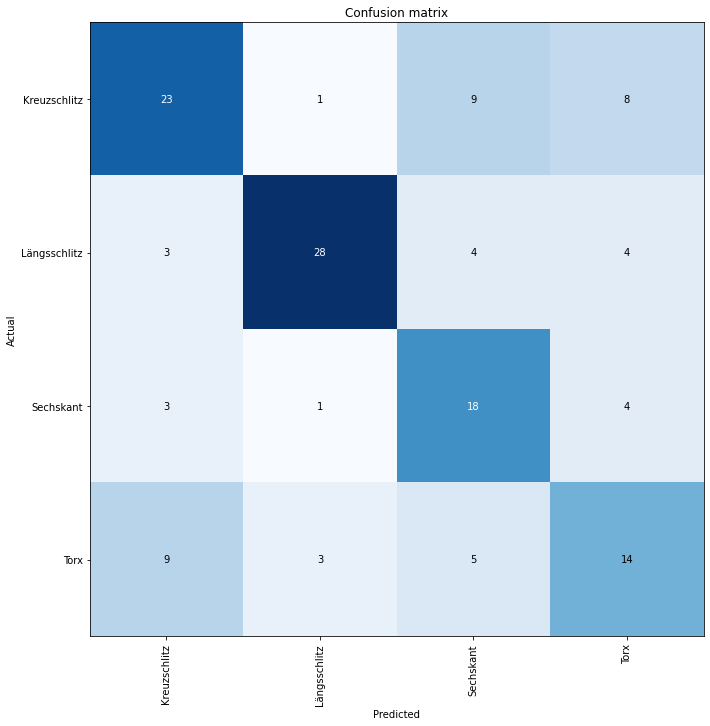

In [87]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

#rows represent all types of screws in dataset
#columns represent images which the model predicted as certain types of screws

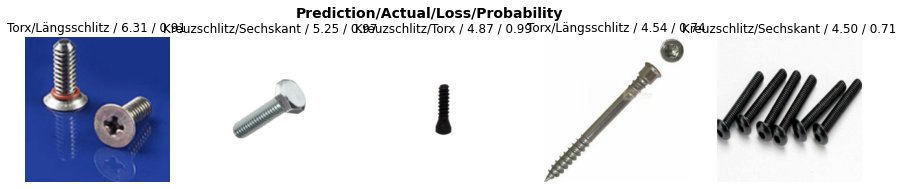

In [88]:
#top losses
interp.plot_top_losses(5, nrows=1)

In [89]:
#most confused
interp.most_confused(min_val=2)

[('Kreuzschlitz', 'Sechskant', 9),
 ('Torx', 'Kreuzschlitz', 9),
 ('Kreuzschlitz', 'Torx', 8),
 ('Torx', 'Sechskant', 5),
 ('Längsschlitz', 'Sechskant', 4),
 ('Längsschlitz', 'Torx', 4),
 ('Sechskant', 'Torx', 4),
 ('Längsschlitz', 'Kreuzschlitz', 3),
 ('Sechskant', 'Kreuzschlitz', 3),
 ('Torx', 'Längsschlitz', 3)]

### 9. Clean your data

Based on the evaluation, you may want to clean your data using the `ImageClassifierCleaner`.
- Remeber to delete the selected data after using the cleaner:
    ```python
    for idx in cleaner.delete(): cleaner.fns[idx].unlink()
    ```
    
    
- Once we've cleaned up our data, we can retrain our model. 



In [90]:
cleaner = ImageClassifierCleaner(learn)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [91]:
cleaner

In [98]:
  for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [99]:
#move images for which we've selected a different category

for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [103]:
#retrain

#learn = cnn_learner(dls, resnet18, metrics=error_rate)
#learn.fine_tune(5)

## Turning Your Model into an Online Application

Now, take your app into production. You can follow the steps from the lecure:

- Export your model via `learn.export`
- Upload your model to [Github Releases](https://docs.github.com/en/free-pro-team@latest/github/administering-a-repository/about-releases) to make it publicly available at your repository.
- Create and upload a new notebook that only contains the necassary code and IPython widgets for your App. 
    - Remeber to download the exported model from *Github Releases*
    - Include a brief description of your app and the functionalities
- Publish your web app on [Binder](https://mybinder.org/) using Voilà

You can use the [example](https://github.com/pds2021/course/blob/main/nbs/07_Bear_App.ipynb) from the lecture as an orientation.

If you're familiar with the world of web application development, you're free to use these skills and all your tools and ressources!

In [104]:
learn.export()

In [105]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [106]:
learn_inf = load_learner(path/'export.pkl')

In [107]:
learn_inf.predict('s1.jpg')

('Längsschlitz',
 tensor(1),
 tensor([5.8116e-03, 9.9371e-01, 4.0607e-04, 7.2814e-05]))

In [108]:
learn_inf.dls.vocab

['Kreuzschlitz', 'Längsschlitz', 'Sechskant', 'Torx']

In [ ]:
###############

## Finally, Provide a Link to Your App

In [ ]:
#############LINK TO APP##################

https://mybinder.org/v2/gh/pds2021/a5-franzislytics/assignment_5?urlpath=%2Fvoila%2Frender%2FKopie_von_Screw_App.ipynb